In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
import scienceplots
plt.style.use(['science', 'grid'])

# Add src to path
sys.path.append(str(Path(os.getcwd()).parent / "src"))

from phd.utils import ResultsManager
from phd.models.cm.analytical_plate import (
    train, exact_solution,
    plot_results, plot_compare, animate, subsample_frames, 
    load_run, save_run_data, continue_training, 
)
from phd.config import book_config
book_config.set_as_current()
results_dir = "analytical_plate_results"
save_fig = True

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



## Forward Problem
We train the model to solve the linear elasticity PDE given boundary conditions.

In [ ]:
# Configure and Train Forward Model
base_config_forward = {
    "task": "forward",
    "n_iter": 50000, 
    "log_every": 200,
    "generate_video": False, # We will generate it manually
    "save_on_disk": False, # Save on disk using timestamp for run directory
    "results_dir": results_dir,
    "net_type": "SPINN",
    "lr_decay": ["warmup cosine", 1e-5, 1e-3, 1000, 50000, 1e-5],
}
configs_forward = {
    "SPINN_forward": base_config_forward,
    "PINN_forward": {**base_config_forward, "net_type": "PINN"},
}

results_forward = {}

run_name = "SPINN_forward" # fixed name for saving/loading
train_model = False
save_run = True
if train_model:
    print("Training Forward Model...")
    results_forward[run_name] = train(configs_forward[run_name])

    if save_run:
        print("Saving run data in directory:", run_name)
        results_forward[run_name]["run_dir"] = Path(configs_forward[run_name]["results_dir"]) / run_name
        save_run_data(results_forward[run_name])
else:
    run_dir_forward = Path(configs_forward[run_name]["results_dir"]) / run_name
    print(f"Loading existing results from {run_dir_forward}...")
    results_forward[run_name] = load_run(run_dir_forward)

Loading existing results from analytical_plate_results/SPINN_forward...


W1203 16:12:01.715631 3715490 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1203 16:12:01.718385 3715351 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


### Forward Results Visualization

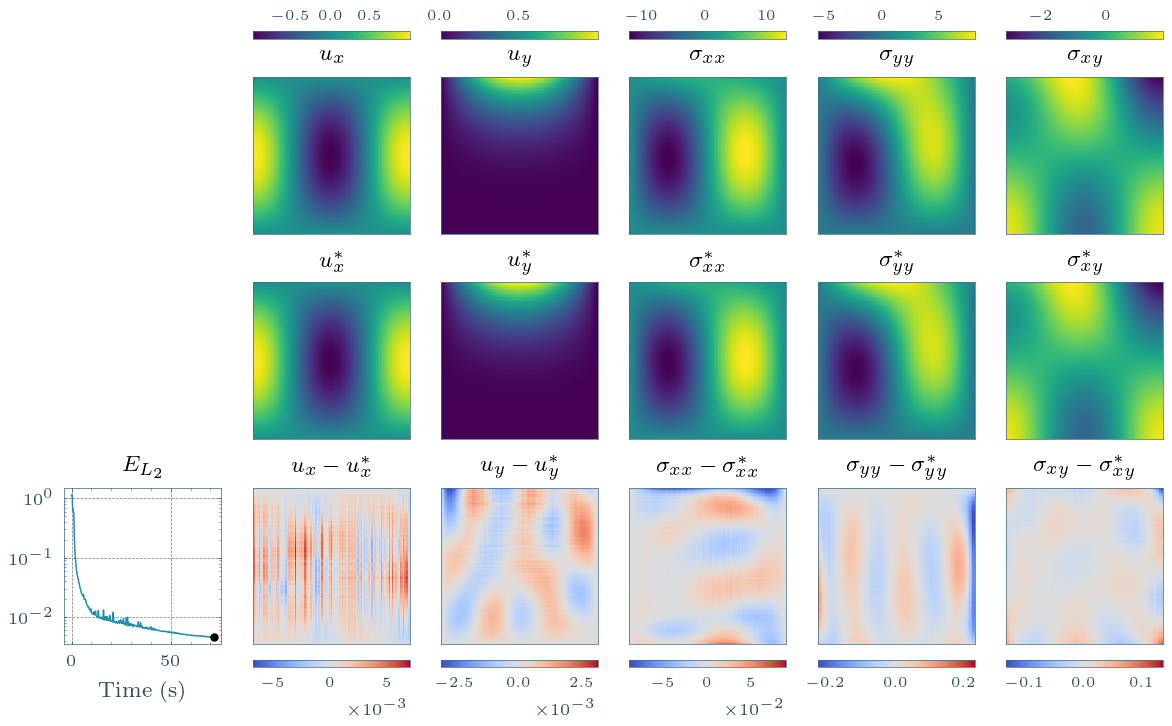

In [6]:
from ipywidgets import interact, IntSlider

fig, artists = plot_results(results_forward[run_name], iteration=-1, dpi=200, step_type="time", time_unit="sec")

# Uncomment to enable interactive plotting
# n_steps = len(results_forward["field_saver"].history)
# @interact(frame_iter=IntSlider(min=0, max=n_steps-1, step=1, value=n_steps-1))
# def plot_interactive(frame_iter):
#     fig, artists = plot_results(results_forward, iteration=frame_iter, dpi=200)
#     plt.show()

In [7]:
# Generate Animation
run_dir_forward = results_forward["run_dir"]
video_path_forward = Path(run_dir_forward) / "training_animation.mp4"

# Create figure and artists
fig, artists = plot_results(results_forward, iteration=0, dpi=200, step_type="time", time_unit="sec", show_iter=True)

# Preview animation with custom frame subsampling (more frames at beginning)
n_frames = len(artists["steps"])
frame_indices = subsample_frames(n_frames, factors=[100])  # Dense start, sparse end
print(f"Subsampled from {n_frames} to {len(frame_indices)} frames")

# Preview duration before saving
animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices, preview=True)

# Uncomment to actually save:
animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices)
# Display Training Animation
Video(video_path_forward, embed=True, html_attributes="controls loop autoplay")

Subsampled from 250 to 4 frames
Animation preview:
  Total available frames: 250
  Selected frames: 4
  FPS: 10
  Duration: 0.4s
Animation saved to analytical_plate_results/forward_SPINN/training_animation.mp4 (4 frames, 0.4s)


In [3]:
run_name = "PINN_forward" # fixed name for saving/loading
train_model = False
save_run = True
if train_model:
    print("Training Forward Model...")
    results_forward[run_name] = train(configs_forward[run_name])

    if save_run:
        print("Saving run data in directory:", run_name)
        results_forward[run_name]["run_dir"] = Path(configs_forward[run_name]["results_dir"]) / run_name
        save_run_data(results_forward[run_name])
else:
    run_dir_forward = Path(configs_forward[run_name]["results_dir"]) / run_name
    print(f"Loading existing results from {run_dir_forward}...")
    results_forward[run_name] = load_run(run_dir_forward)


Loading existing results from analytical_plate_results/PINN_forward...


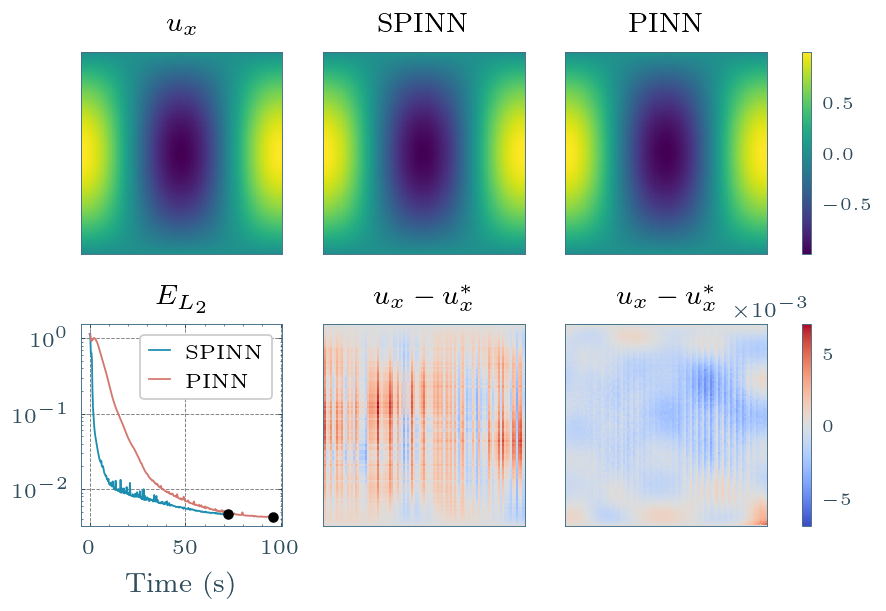

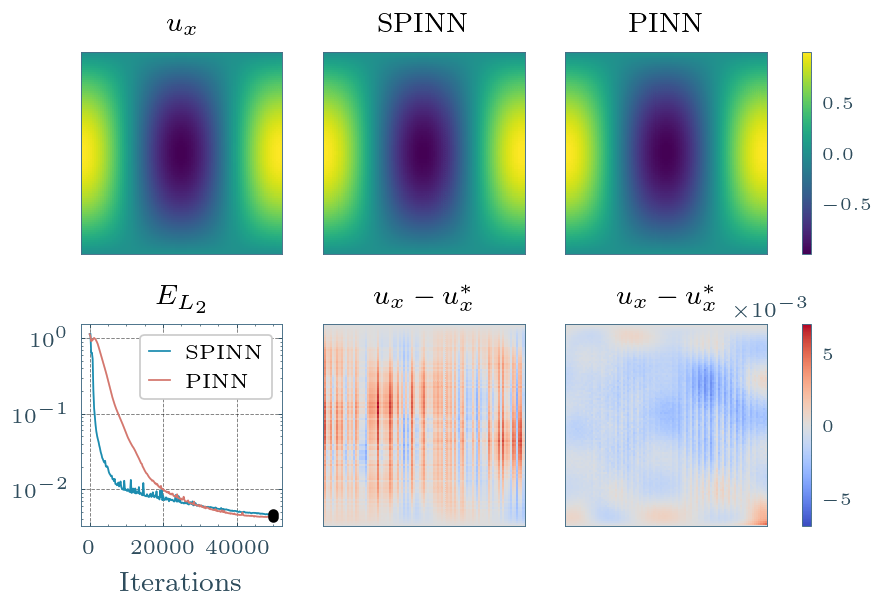

In [11]:
# Plot comparison between SPINN and PINN
fig, artists = plot_compare(
    results_forward["SPINN_forward"], 
    results_forward["PINN_forward"],
    exact_solution_fn= exact_solution,
    run_names=["SPINN", "PINN"],
    iteration=-1, dpi=250,
    step_type="time", time_unit="sec",
    # show_iter=True
)
if save_fig:
    fig.savefig(os.path.join(results_dir, "spinn_vs_pinn_time.png"), dpi=300)

fig, artists = plot_compare(
    results_forward["SPINN_forward"], 
    results_forward["PINN_forward"],
    exact_solution_fn= exact_solution,
    run_names=["SPINN", "PINN"],
    iteration=-1, dpi=250,
)
if save_fig:
    fig.savefig(os.path.join(results_dir, "spinn_vs_pinn_iter.png"), dpi=300)

In [ ]:
# Generate Animation
run_dir_forward = results_forward[run_name]["run_dir"]
video_path_forward = Path(run_dir_forward) / "training_animation.mp4"


fig, artists = plot_compare(
    results_forward["SPINN_forward"], 
    results_forward["PINN_forward"],
    exact_solution_fn= exact_solution,
    run_names=["SPINN", "PINN"],
    iteration=-1, dpi=250,
    step_type="time", time_unit="sec",
    show_iter=True
)

# Preview animation with custom frame subsampling (more frames at beginning)
n_frames = len(artists["steps"])
frame_indices = subsample_frames(n_frames, factors=[1,2,3,4,4,4,4,4])  # Dense start, sparse end
print(f"Subsampled from {n_frames} to {len(frame_indices)} frames")

# Preview duration before saving
animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices, preview=True)

# Uncomment to actually save:
animate(fig, artists, video_path_forward, fps=10, frame_indices=frame_indices)
# Display Training Animation
Video(video_path_forward, embed=True, html_attributes="controls loop autoplay")

Subsampled from 250 to 99 frames
Animation preview:
  Total available frames: 250
  Selected frames: 99
  FPS: 10
  Duration: 9.9s
Animation saved to analytical_plate_results/PINN_forward/training_animation.mp4 (99 frames, 9.9s)


## Inverse Problem
We train the model to discover material parameters ($\lambda, \mu$) from synthetic data.

In [4]:
# Configure and Train Inverse Model
n_iter = 75000
base_config_inverse = {
    "task": "inverse",
    "n_iter": n_iter,
    "log_every": 250,
    "generate_video": False, # Automatic generation disabled
    "save_on_disk": False, # Save on disk using timestamp for run directory
    "results_dir": results_dir,
    "net_type": "SPINN",
    "lmbd_init": 2.0, # Initial guess
    "mu_init": 0.3,   # Initial guess
    "lmbd": 1.0,      # Target
    "mu": 0.5,        # Target
    "n_DIC": 10,       # Number of DIC points (10x10)
    "lr_decay": ["warmup cosine", 1e-5, 1e-3, 1000, n_iter, 1e-5]
}

config_inverse = {"SPINN_inverse": base_config_inverse,
                    "PINN_inverse": {**base_config_inverse, "net_type": "PINN",
                                   "lr_decay": ["warmup cosine", 1e-3, 1e-3, 3000, n_iter, 1e-4]}, # Train longer at higher LR
                    "PINN_inverse_350k": {**base_config_inverse, "net_type": "PINN", "n_iter": 350000, "log_every": 1000,
                                      "lr_decay": ["warmup cosine", 1e-3, 1e-3, 300000, 350000, 1e-4]},
                    "PINN_inverse_enhanced": {**base_config_inverse, "net_type": "PINN", "n_iter": 100000, "log_every": 500,
                                      "lr_decay": ["warmup cosine", 1e-3, 1e-3, 50000, 100000, 1e-4],
                                      "variables_training_factors": [0.1, 0.1]}}


run_name = "SPINN_inverse" # fixed name for saving/loading
if "results_inverse" not in locals():
    results_inverse = {}

train_model = False
save_run = True
if train_model:
    print("Training Inverse Model...")
    results_inverse[run_name] = train(config_inverse[run_name])
    if save_run:
        results_inverse[run_name]["run_dir"] = Path(config_inverse[run_name]["results_dir"]) / run_name
        save_run_data(results_inverse[run_name])
else:
    run_dir_inverse = Path(config_inverse[run_name]["results_dir"]) / run_name
    results_inverse[run_name] = load_run(run_dir_inverse)
        

### Inverse Results Visualization

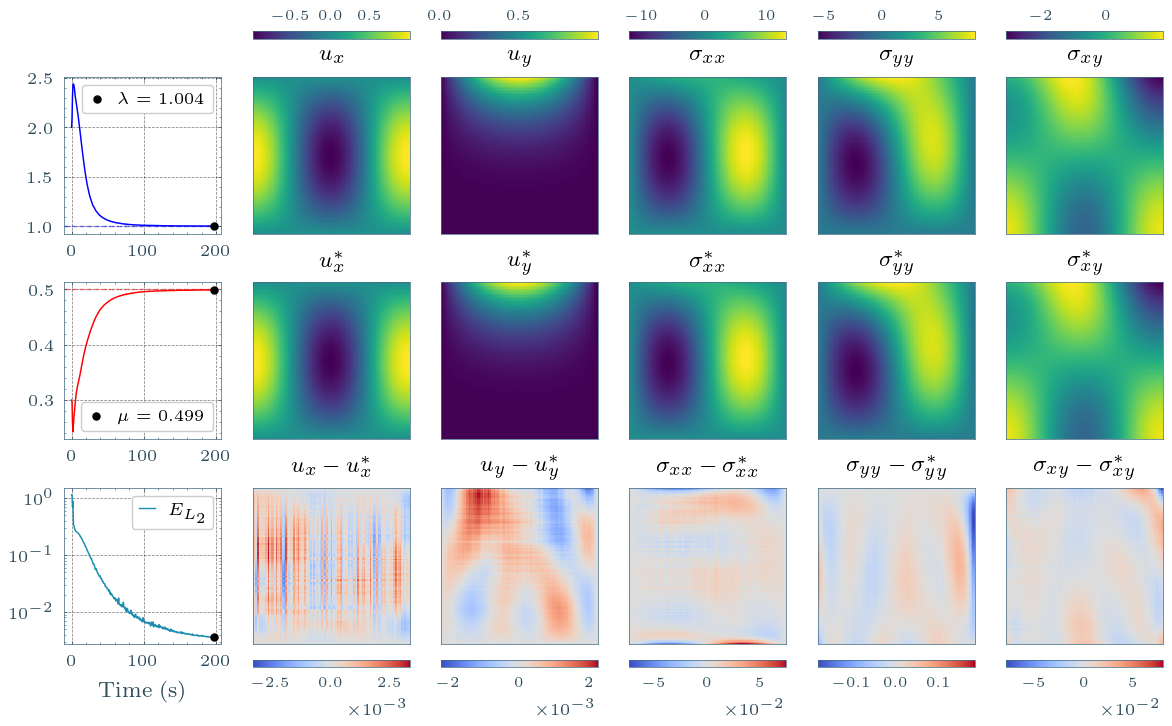

In [38]:
# Create figure and artists
run_name = "SPINN_inverse" 
step = len(results_inverse[run_name]["losshistory"].steps)-2
fig_inv, artists_inv = plot_results(results_inverse[run_name], iteration=step, dpi=200, step_type="time", time_unit="sec")

if save_fig:
    fig_inv.savefig(os.path.join(results_dir, "inverse_spinn_75k.png"), dpi=300)

In [37]:
# Generate Animation for Inverse Problem
video_path_inverse = results_inverse[run_name]["run_dir"] / "training_animation.mp4"
print("Generating animation...")

# Custom frame subsampling - more detail at the beginning
n_frames = len(artists_inv["steps"])
frame_indices = subsample_frames(n_frames, factors=[1, 2, 3, 4, 5, 5, 5])

# Preview
animate(fig_inv, artists_inv, video_path_inverse, fps=10, frame_indices=frame_indices, preview=True)

# Save
fig_inv, artists_inv = plot_results(results_inverse[run_name], iteration=0, dpi=200, step_type="time", time_unit="min", show_iter=True)
animate(fig_inv, artists_inv, video_path_inverse, fps=10, frame_indices=frame_indices)
# Display Inverse Training Animation
Video(video_path_inverse, embed=True, html_attributes="controls loop autoplay")

Generating animation...
Animation preview:
  Total available frames: 300
  Selected frames: 117
  FPS: 10
  Duration: 11.7s
Animation saved to analytical_plate_results/SPINN_inverse/training_animation.mp4 (117 frames, 11.7s)


In [5]:
run_name = ["PINN_inverse","PINN_inverse_350k","PINN_inverse_enhanced"][2]
train_model = True
save_run = True
if train_model:
    print(f"Training Model: {run_name}")
    results_inverse[run_name] = train(config_inverse[run_name])

    if save_run:
        print("Saving run data in directory:", run_name)
        results_inverse[run_name]["run_dir"] = Path(config_inverse[run_name]["results_dir"]) / run_name
        save_run_data(results_inverse[run_name])
else:
    run_dir_inverse = Path(config_inverse[run_name]["results_dir"]) / run_name
    print(f"Loading existing results from {run_dir_inverse}...")
    results_inverse[run_name] = load_run(run_dir_inverse, restore_model=True)

Training Model: PINN_inverse_enhanced
Compiling model...
'compile' took 2.813225 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric   
0         [1.79e+03, 2.58e+02, 1.04e-02, 3.01e+01, 9.39e-02, 2.46e-01, 6.30e-02]    [1.78e+03, 2.58e+02, 1.09e-02, 3.10e+01, 9.31e-02, 2.46e-01, 6.30e-02]    [1.13e+00]    
500       [1.03e+02, 2.94e+01, 2.58e+00, 5.62e+00, 2.48e+01, 2.18e-01, 9.65e-02]    [1.00e+02, 2.84e+01, 2.57e+00, 5.58e+00, 2.40e+01, 2.18e-01, 9.65e-02]    [9.68e-01]    
1000      [2.00e+01, 3.75e+00, 2.05e+00, 4.70e+00, 3.03e+01, 7.87e-02, 1.00e-01]    [1.95e+01, 3.39e+00, 1.91e+00, 4.40e+00, 2.88e+01, 7.87e-02, 1.00e-01]    [1.00e+00]    
1500      [7.75e+00, 1.33e+00, 1.34e+00, 3.42e+00, 2.50e+01, 4.40e-02, 1.33e-01]    [7.79e+00, 9.88e-01, 1.22e+00, 3.23e+00, 2.36e+01, 4.40e-02, 1.33e-01]    [9.02e-01]    
2000      [4.56e+00, 1.11e+00, 8

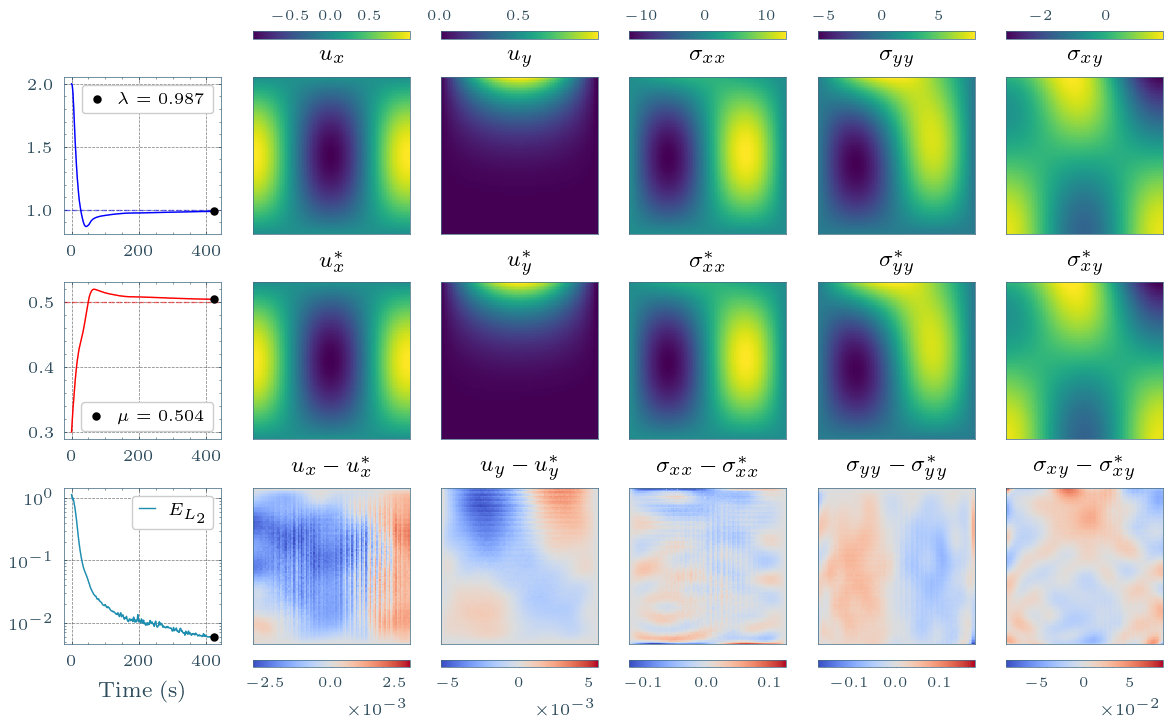

In [9]:
# Create figure and artists
run_name = ["PINN_inverse","PINN_inverse_enhanced","PINN_inverse_350k"][1]

step = -1
fig_inv, artists_inv = plot_results(results_inverse[run_name], iteration=step, dpi=200, step_type="time", time_unit="sec")
if save_fig:
    suffix = "75k" if run_name=="PINN_inverse" else run_name.split("_")[-1]
    fig_inv.savefig(os.path.join(results_dir, f"inverse_pinn_{suffix}.png"), dpi=300)

In [30]:
results_inverse.keys()

dict_keys(['SPINN_inverse'])